In [1]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [58]:
from lagrangian_trajectory_clustering.data_loading import (
    load_cape_verde_trajectories,
    subset_trajectories,
    reindex_trajectories,
)

ImportError: cannot import name 'reindex_trajectories' from 'lagrangian_trajectory_clustering.data_loading' (/work/lagrangian_trajectory_clustering/data_loading.py)

In [3]:
# parameters

num_traj = 1_000
year = 2017
lat_lon_res = 7

In [4]:
raw_data = subset_trajectories(
    load_cape_verde_trajectories(year=year),
    num_traj=num_traj,
    use_random=True,
    random_seed=456,
)[["longitude", "latitude"]]

display(raw_data)

longitude   latitude
traj obs                      
8    0   -22.691607  16.029816
     1   -22.685192  15.991036
     2   -22.683147  15.967465
     3   -22.692963  15.966416
     4   -22.705220  15.973639
...             ...        ...
9964 253 -49.320366  10.847726
     254 -49.505756  10.759947
     255 -49.673706  10.700109
     256 -49.828434  10.668164
     257 -49.828434  10.668164

[292061 rows x 2 columns]

In [5]:
import pandas as pd
import numpy as np

In [7]:
new_trai = pd.Series(np.arange(num_traj), index=raw_data.index.levels[0], name="new_traj")

raw_data = (
    raw_data
    .join(new_trai)
    .reset_index()
    .rename(columns={"traj": "old_traj"})
    .rename(columns={"new_traj": "traj"})
    .set_index(["traj", "obs"])
)

In [8]:
from lagrangian_trajectory_clustering.trafo.grid import (
    geo_df_to_grid_series,  # lat lon coords to grid index
    grid_series_to_geo_df,  # grid index to lat lon coords
)

from lagrangian_trajectory_clustering.trafo.sequence import (
    remove_subsequent_identical_elements,  # transorm to sequence of unique subsequent elemets
    multi_index_series_to_series_sequences,  # transform to series of sequences
    series_sequences_to_multi_index_series,  # transform back from series of sequences
    fill_in_segments,  # fill in jumps leaping over grid boxes
)

In [9]:
lat_num = int(180 // (abs(raw_data.latitude.max() - raw_data.latitude.min()) / lat_lon_res) + 1)
lon_num = int(360 // (abs(raw_data.longitude.max() - raw_data.longitude.min()) / lat_lon_res) + 1)
print(lon_num, lat_num)

58 93


In [38]:
print(360 / (lon_num - 1), 180 / (lat_num - 1))

6.315789473684211 1.9565217391304348


In [10]:
raw_data_roundtrip = grid_series_to_geo_df(
    series_sequences_to_multi_index_series(
        fill_in_segments(
            remove_subsequent_identical_elements(
                multi_index_series_to_series_sequences(
                    geo_df_to_grid_series(
                        raw_data,
                        lon_num=lon_num,
                        lat_num=lat_num,
                    )
                )
            )
        )
    ),
    lon_num=lon_num,
    lat_num=lat_num,
)

display(raw_data_roundtrip)

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


longitude   latitude
traj obs                       
0    0    337.894737  16.630435
     1    337.894737  14.673913
     2    331.578947  14.673913
     3    325.263158  14.673913
     4    325.263158  16.630435
...              ...        ...
999  5    318.947368  12.717391
     6    318.947368  10.760870
     7    312.631579  10.760870
     8    312.631579  12.717391
     9    312.631579  10.760870

[10158 rows x 2 columns]

In [11]:
from matplotlib import pyplot as plt
import cartopy

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


CPU times: user 18.8 s, sys: 155 ms, total: 19 s
Wall time: 18.8 s


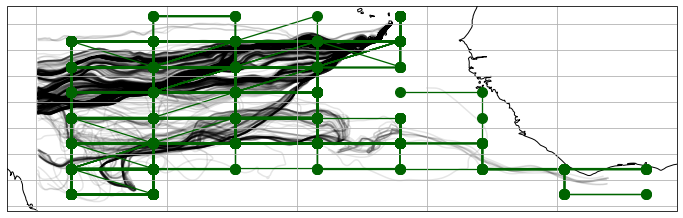

In [37]:
%%time

fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 12),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)

(
    raw_data
    .groupby("traj")
    .plot.line(
        x="longitude", y="latitude",
        ax=ax, legend=False,
        alpha=0.1, color="black",
        transform=cartopy.crs.PlateCarree()
    )
)

(
    raw_data_roundtrip
    .groupby("traj")
    .plot.line(
        x="longitude", y="latitude",
        ax=ax, legend=False,
        alpha=1, color="darkgreen", linewidth=1.3, marker="o", markersize=10,
        transform=cartopy.crs.PlateCarree()
    )
)

ax.gridlines()
ax.coastlines()
ax.set_yticks([])
_ = ax.set_ylabel("");

In [13]:
sequential_data = fill_in_segments(
    remove_subsequent_identical_elements(
        multi_index_series_to_series_sequences(
            geo_df_to_grid_series(
                raw_data,
                lon_num=lon_num,
                lat_num=lat_num,
            )
        )
    )
)

display(sequential_data)

traj
0      [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
1      [(53, 54), (53, 53), (52, 53), (52, 54), (51, ...
2      [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
3      [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
4      [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
                             ...                        
995    [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
996    [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
997    [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
998    [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
999    [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
Name: grid_index_lon_lat, Length: 1000, dtype: object

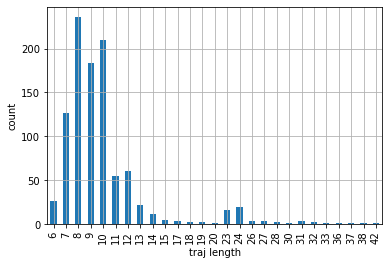

In [53]:
ax = sequential_data.apply(len).value_counts().sort_index().plot.bar();
ax.grid()
ax.set_xlabel("traj length")
ax.set_ylabel("count");

In [54]:
sequential_data.apply(len).describe()

count    1000.000000
mean       10.158000
std         4.461944
min         6.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        42.000000
Name: grid_index_lon_lat, dtype: float64

In [15]:
from lagrangian_trajectory_clustering.metrics import levenshtein_numpy_numba, lcs_numpy_numba
from lagrangian_trajectory_clustering.metrics_wrapped import wrapped_metric

In [16]:
import numpy as np

In [17]:
lcs_dist = lambda s0, s1: min(len(s0), len(s1)) / lcs_numpy_numba(s0, s1) - 1

In [18]:
from sklearn.cluster import OPTICS
import pandas as pd

In [19]:
metric = wrapped_metric(
    metric_function=lcs_dist,
    sequences_mapping=sequential_data,
    normalize=False,
)

CPU times: user 6min 44s, sys: 2.5 s, total: 6min 47s
Wall time: 6min 44s


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


<AxesSubplot:xlabel='traj'>

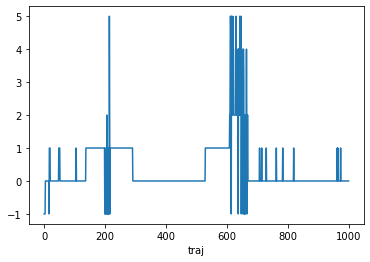

In [20]:
%%time

clust = OPTICS(
    metric=metric,
)

cluster_id = pd.Series(
    clust.fit_predict(np.arange(num_traj).reshape(-1, 1)),
    index=sequential_data.index,
    name="cluster_id"
)

cluster_id.plot()

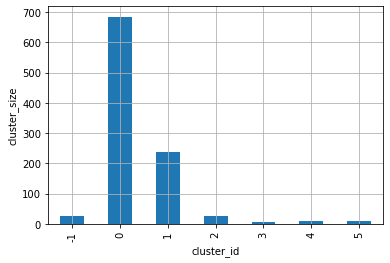

In [27]:
ax = cluster_id.value_counts().sort_index().plot.bar()
ax.set_xlabel("cluster_id")
ax.set_ylabel("cluster_size")
ax.grid();

In [22]:
# _data = raw_data_roundtrip.join(cluster_id)
_data = raw_data.join(cluster_id)

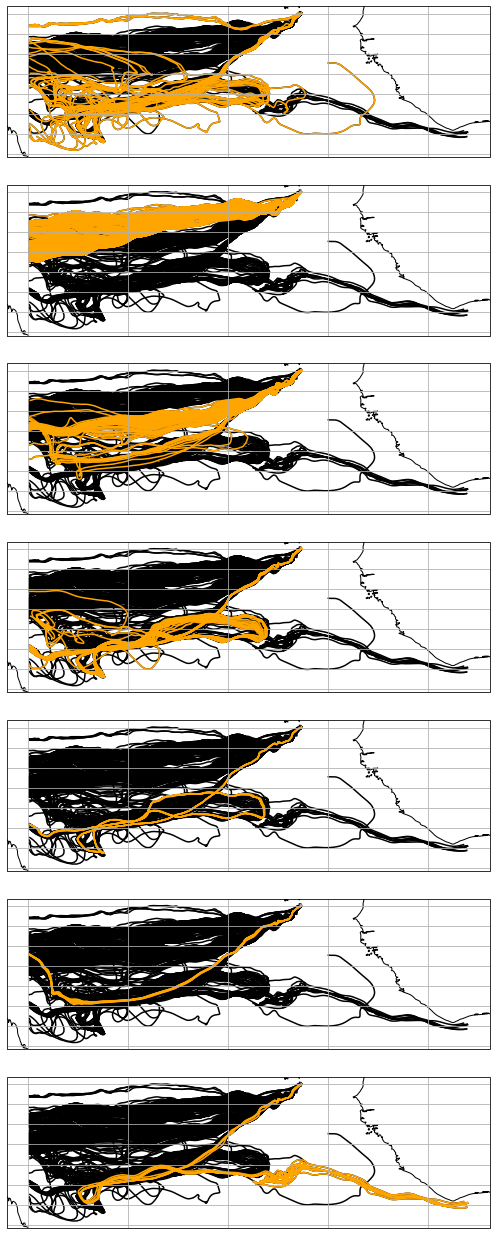

In [23]:
fig, ax = plt.subplots(
    len(cluster_id.unique()), 1,
    figsize=(7, 2.5*len(cluster_id.unique())),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    sharex=True, sharey=True,
)

for _ax, cid in zip(ax.flatten(), sorted(cluster_id.unique())):
    (
        _data
        .groupby("traj")
        .plot.line(
            x="longitude", y="latitude",
            ax=_ax, legend=False,
            alpha=1, color="black",
            transform=cartopy.crs.PlateCarree()
        )
    )
    
    (
        _data[_data["cluster_id"] == cid]
        .groupby("traj")
        .plot.line(
            x="longitude", y="latitude",
            ax=_ax, legend=False,
            alpha=1, color="orange",
            transform=cartopy.crs.PlateCarree()
        )
    )

    _ax.gridlines()
    _ax.coastlines()
    _ax.set_yticks([])
    _ax.set_ylabel("");
    
fig.tight_layout();

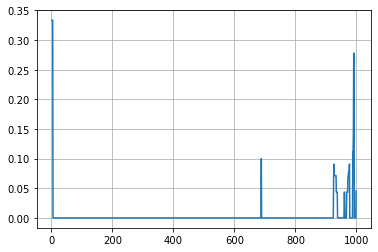

In [29]:
ax = pd.Series(clust.reachability_[clust.ordering_]).plot()
ax.grid();

## Subset to biggest cluster

In [75]:
raw_data_1 = raw_data.join(cluster_id).reset_index().set_index(["cluster_id", "traj", "obs"])
raw_data_1_0 = raw_data_1.loc[0].reset_index().set_index(["traj", "obs"])
raw_data_1_0

old_traj  longitude   latitude
traj obs                                
4    0          40 -22.692282  16.033049
     1          40 -22.749298  16.032228
     2          40 -22.764538  16.034508
     3          40 -22.774569  16.018383
     4          40 -22.818733  15.991084
...            ...        ...        ...
999  253      9964 -49.320366  10.847726
     254      9964 -49.505756  10.759947
     255      9964 -49.673706  10.700109
     256      9964 -49.828434  10.668164
     257      9964 -49.828434  10.668164

[178615 rows x 3 columns]

In [76]:
new_trai = pd.Series(np.arange(len(raw_data_1_0.index.levels[0])), index=raw_data_1_0.index.levels[0], name="new_traj")

raw_data_1_0 = (
    raw_data_1_0
    .join(new_trai)
    .reset_index()
    .rename(columns={"traj": "old_traj"})
    .rename(columns={"new_traj": "traj"})
    .set_index(["traj", "obs"])
)
                     
raw_data_1_0

old_traj  old_traj  longitude   latitude
traj obs                                          
0    0           4        40 -22.692282  16.033049
     1           4        40 -22.749298  16.032228
     2           4        40 -22.764538  16.034508
     3           4        40 -22.774569  16.018383
     4           4        40 -22.818733  15.991084
...            ...       ...        ...        ...
683  253       999      9964 -49.320366  10.847726
     254       999      9964 -49.505756  10.759947
     255       999      9964 -49.673706  10.700109
     256       999      9964 -49.828434  10.668164
     257       999      9964 -49.828434  10.668164

[178615 rows x 4 columns]

In [80]:
sequential_data_1_0 = fill_in_segments(
    remove_subsequent_identical_elements(
        multi_index_series_to_series_sequences(
            geo_df_to_grid_series(
                raw_data_1_0,
                lon_num=2 * lon_num,
                lat_num=2 * lat_num,
            )
        )
    )
)

display(sequential_data_1_0)

traj
0      [(107, 108), (106, 108), (106, 107), (106, 106...
1      [(107, 108), (107, 107), (106, 107), (106, 108...
2      [(107, 108), (107, 107), (106, 107), (106, 106...
3      [(107, 108), (107, 107), (107, 108), (107, 107...
4      [(107, 108), (107, 107), (107, 108), (107, 107...
                             ...                        
679    [(107, 108), (107, 107), (107, 106), (106, 106...
680    [(107, 108), (107, 107), (107, 106), (106, 106...
681    [(107, 108), (107, 107), (107, 106), (106, 106...
682    [(107, 108), (107, 107), (107, 106), (106, 106...
683    [(107, 108), (107, 107), (107, 106), (106, 106...
Name: grid_index_lon_lat, Length: 684, dtype: object

In [82]:
raw_data_roundtrip_1_0 = grid_series_to_geo_df(
    series_sequences_to_multi_index_series(
        fill_in_segments(
            remove_subsequent_identical_elements(
                multi_index_series_to_series_sequences(
                    geo_df_to_grid_series(
                        raw_data_1_0,
                        lon_num=2 * lon_num,
                        lat_num=2 * lat_num,
                    )
                )
            )
        )
    ),
    lon_num=2 * lon_num,
    lat_num=2 * lat_num,
)

display(raw_data_roundtrip_1_0)

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


longitude   latitude
traj obs                       
0    0    336.521739  15.567568
     1    333.391304  15.567568
     2    333.391304  14.594595
     3    333.391304  13.621622
     4    330.260870  13.621622
...              ...        ...
683  12   320.869565  11.675676
     13   317.739130  11.675676
     14   314.608696  11.675676
     15   311.478261  11.675676
     16   311.478261  10.702703

[11073 rows x 2 columns]

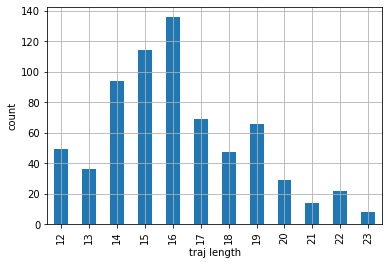

In [83]:
ax = sequential_data_1_0.apply(len).value_counts().sort_index().plot.bar();
ax.grid()
ax.set_xlabel("traj length")
ax.set_ylabel("count");

In [95]:
sequential_data_1_0.apply(len).describe()

count    684.000000
mean      16.188596
std        2.544673
min       12.000000
25%       14.000000
50%       16.000000
75%       18.000000
max       23.000000
Name: grid_index_lon_lat, dtype: float64

CPU times: user 11.4 s, sys: 139 ms, total: 11.5 s
Wall time: 11.3 s


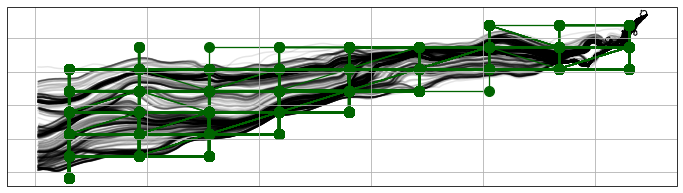

In [84]:
%%time

fig, ax = plt.subplots(
    1, 1,
    figsize=(12, 12),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)

(
    raw_data_1_0
    .groupby("traj")
    .plot.line(
        x="longitude", y="latitude",
        ax=ax, legend=False,
        alpha=0.1, color="black",
        transform=cartopy.crs.PlateCarree()
    )
)

(
    raw_data_roundtrip_1_0
    .groupby("traj")
    .plot.line(
        x="longitude", y="latitude",
        ax=ax, legend=False,
        alpha=1, color="darkgreen", linewidth=1.3, marker="o", markersize=10,
        transform=cartopy.crs.PlateCarree()
    )
)

ax.gridlines()
ax.coastlines()
ax.set_yticks([])
_ = ax.set_ylabel("");

In [85]:
metric = wrapped_metric(
    metric_function=lcs_dist,
    sequences_mapping=sequential_data_1_0,
    normalize=False,
)

CPU times: user 4min 38s, sys: 874 ms, total: 4min 39s
Wall time: 4min 38s


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


<AxesSubplot:xlabel='traj'>

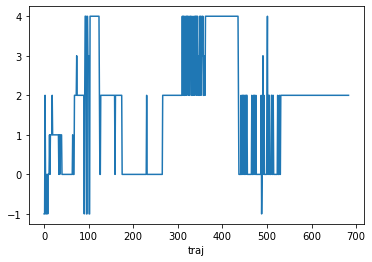

In [87]:
%%time

clust = OPTICS(
    metric=metric,
)

cluster_id = pd.Series(
    clust.fit_predict(np.arange(len(sequential_data_1_0.index)).reshape(-1, 1)),
    index=sequential_data_1_0.index,
    name="cluster_id"
)

cluster_id.plot()

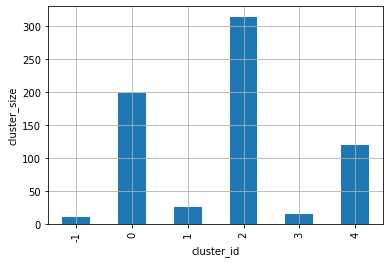

In [90]:
ax = cluster_id.value_counts().sort_index().plot.bar()
ax.set_xlabel("cluster_id")
ax.set_ylabel("cluster_size")
ax.grid();

In [88]:
# _data = raw_data_roundtrip.join(cluster_id)
_data = raw_data_1_0.join(cluster_id)

CPU times: user 1min 13s, sys: 1.02 s, total: 1min 14s
Wall time: 1min 13s


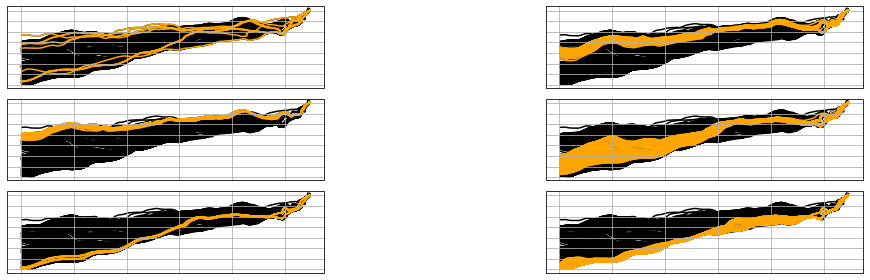

In [98]:
%%time

fig, ax = plt.subplots(
    len(cluster_id.unique()) // 2, 2,
    figsize=(6 * len(cluster_id.unique()) // 2, 2 * 2),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    sharex=True, sharey=True,
)

for _ax, cid in zip(ax.flatten(), sorted(cluster_id.unique())):
    (
        _data
        .groupby("traj")
        .plot.line(
            x="longitude", y="latitude",
            ax=_ax, legend=False,
            alpha=1, color="black",
            transform=cartopy.crs.PlateCarree()
        )
    )
    
    (
        _data[_data["cluster_id"] == cid]
        .groupby("traj")
        .plot.line(
            x="longitude", y="latitude",
            ax=_ax, legend=False,
            alpha=1, color="orange",
            transform=cartopy.crs.PlateCarree()
        )
    )

    _ax.gridlines()
    _ax.coastlines()
    _ax.set_yticks([])
    _ax.set_ylabel("");
    
_ = fig.tight_layout();

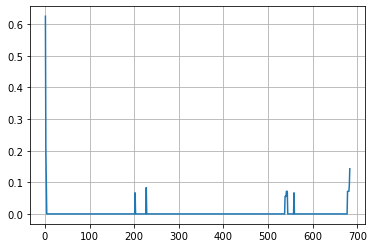

In [97]:
ax = pd.Series(clust.reachability_[clust.ordering_]).plot()
ax.grid();